# Modelo de previsão de interrupção de energia



Uma ocorrencia de energia pode ser acarretada por diversos fatores, sejam externos ou internos, programadas ou não programadas.

Desta forma, o objetivo aqui é criar uma maneira automática para identificação de interrupção de energia, de modo a auxiliar distribuidoras de energia no trabalho proativo para evitar maiores transtornos aos clientes

## Objetivo
O objetivo é identificar variáveis importantes e definir o melhor modelo analítico para inferir na previsibilidade de interrupção de energia.

Esta análise será dividida em 5 macro etapas:
1. Exploratory Data Analysis (EDA)
2. Data Pre-Processing
3. Feature engineering
4. Modeling
5. Hyperparameter tunning




In [31]:
# Dataframe
from google.cloud import bigquery
from google.colab import data_table
import pandas as pd
pd.set_option('display.max_columns', None)
import pandas_gbq as gbq
import numpy as np

# Others
from datetime import datetime

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import train_test_split


## Sobre o Dataset
Abaixo temos maiores detalhes a respeito do dataset:
- `distribuidora`: Nome ficticio da distribuidora de energia em questão
- `ocorrencia`: ID da ocorrencia gerado no sistema interno da distribuidora
- `idConjunto`: ID do conjunto elétrico, caracterizado por um conjunto de elementos elétricos
- `canalAtendimento`: Canal de atendimento na qual a ocorrencia foi registrada
- `inicioOcorrencia`: Data de inicio em que a ocorrencia foi registrada no sistema
- `fimOcorrencia`: Data de finalização da ocorrencia no sistema
- `duracaoOcorrencia`: Duranção da ocorrencia
- `descricaoOcorrencia`: Descrição da ocorrencia
- `NumInterrupcao`: ID da interrupção (caso tenha acontecido)
- `OrdemInterrupcao`:
- `tipoInterrupcao`: Descreve o tipo da interrupção
- `idMotivoInterrupcao`: ID do motivo da interrupção
- `inicioInterrupcao`: Data do inicio da interrupção registrada no sistema
- `fimInterrupcao`: Data do fim da interrupção registrada no sistema
- `duracaoInterrupcao`: Duranção da interrupção
- `causaRaiz`: Causa raíz da interrupção
- `QtdConsAtivo`: Quantidade de consumidores ativos
- `mesUltimaInspecao`: Mes da ultima inspeção de rede daquele conjunto elétrico
- `anoUltimaInspecao`: Ano da ultima inspeção de rede daquele conjunto elétrico
- `mesUltimaManutencaoPrev`: Mes da ultima manutenção preventiva de rede daquele conjunto elétrico
- `anoUltimaManutencaoPrev`: Ano da ultima manutenção preventiva de rede daquele conjunto elétrico
- `mesUltimaManutencaoCorr`: Mes da ultima manutenção corretiva de rede daquele conjunto elétrico
- `anoUltimaManutencaoCorr`: Ano da ultima manutenção corretiva de rede daquele conjunto elétrico
- `isInterrupcao`: Flag que destaca se houve uma interrupção de energia

Fonte dos dados:
- Percentual de carregamento, dados de inspeção, manutenção e etc.
https://dadosabertos.aneel.gov.br/dataset/indger-indicadores-gerenciais-da-distribuicao


- DEC e FEC
https://dadosabertos.aneel.gov.br/dataset/indicadores-coletivos-de-continuidade-dec-e-fec

- Ocorrência
https://dadosabertos.aneel.gov.br/dataset/ocorrencias-emergenciais-nas-redes-de-distribuicao


- Interrupção do cliente
https://dadosabertos.aneel.gov.br/dataset/interrupcoes-de-energia-eletrica-nas-redes-de-distribuicao

## Leitura do dataset tecnico

In [32]:
sql = """
  SELECT
    *
  FROM
    `tcc-usp-esalq-007.consumer_layer.tb_dados_finais`
"""

df_tecnico = gbq.read_gbq(sql, project_id='tcc-usp-esalq-007')

Downloading: 100%|██████████|


In [33]:
df_tecnico.head(3)

,distribuidora,ocorrencia,idConjunto,canalAtendimento,InicioOcorrencia,FimOcorrencia,duracaoOcorrencia,descricaoOcorrencia,NumInterrupcao,OrdemInterrupcao,tipoInterrupcao,idMotivoInterrupcao,inicioInterrupcao,fimInterrupcao,duracaoInterrupcao,causaRaiz,QtdConsAtivo,mesUltimaInspecao,anoUltumaInspecao,mesUltimaManutencaoPrev,anoUltimaManutencaoPrev,mesUltimaManutencaoCorr,anoUltimaManutencaoCorr,isInterrupcao
0,ERSA,2023-1383662,13569,Callcenter,2023-11-09 14:58:00+00:00,2023-11-10 10:14:00+00:00,1156,Interna;Nao Programada;Nao Classificada,S/I,None,None,<NA>,NaT,NaT,<NA>,None,7300,12,2023,9,2023,9,2023,N
1,ERSA,2023-620028,13569,Callcenter,2023-05-27 15:25:00+00:00,2023-05-27 21:42:00+00:00,377,Interna;Nao Programada;Terceiros;Defeito Inter...,S/I,None,None,<NA>,NaT,NaT,<NA>,None,7300,12,2023,9,2023,9,2023,N
2,ERSA,2023-1271406,13569,Callcenter,2023-10-23 12:37:00+00:00,2023-10-23 21:49:00+00:00,552,Interna;Nao Programada;Proprias do Sistema;Nao...,S/I,None,None,<NA>,NaT,NaT,<NA>,None,7300,12,2023,9,2023,9,2023,N


In [34]:
df_tecnico.shape

(696446, 24)

## Leitura do dataset climático
Abaixo temos maiores detalhes a respeito do dataset:
- `DATA_OBSERVACAO`: Data de medição das métricas climáticas (UTC)
- `HORA_UTC`: Horario de medição das métricas climáticas (UTC)
- `DISTRIBUIDORA`: Distribuidora de energia que contem a consessao da regiao
- `PRECIPITACAO`: Precipitacao medida (chuva) em mm
- `PRESSAO_ATMOSFERICA`: Pressao atmosferica medida (mB)
- `RADIACAO_GLOBAL`: Radiacao solar medida (KJ/m≤)
- `TEMPERATURA_AR`: Temperatura do ar medida (∞C)
- `UMIDADE_RELATIVA_AR`: Umidade relativa do ar medida (%)
- `VENTO_DIRECAO_HORARIA`: Vento na direcao horaria medida (∞(gr))
- `VENTO_RAJADA_MAXIMA`: Vento de rajada maximo (m/s)
- `VENTO_VELOCIDADE_HORARIA`: Velocidade do vento na direcao horaria (m/s)


Fonte dos dados:
- https://portal.inmet.gov.br/dadoshistoricos

In [35]:
sql = """
  SELECT
    *
  FROM
    `tcc-usp-esalq-007.consumer_layer.tb_dados_climaticos`
"""

df_clima = gbq.read_gbq(sql, project_id='tcc-usp-esalq-007')

Downloading: 100%|██████████|


In [36]:
df_clima.head(3)

,DATA_OBSERVACAO,HORA_UTC,DISTRIBUIDORA,PRECIPITACAO,PRESSAO_ATMOSFERICA,RADIACAO_GLOBAL,TEMPERATURA_AR,UMIDADE_RELATIVA_AR,VENTO_DIRECAO_HORARIA,VENTO_RAJADA_MAXIMA,VENTO_VELOCIDADE_HORARIA
0,2024-09-05,02,NDBSA,0.0,0.0,0.0,0.0,0,0,0.0,0.0
1,2024-03-22,00,NDBSA,0.0,887.1,0.0,21.5,91,282,1.8,0.3
2,2023-03-11,04,NDBSA,0.0,886.4,0.0,17.7,90,282,2.3,0.3


## Tratamento de *dados*

### Tratamento dos valores climáticos
Cria features e prepara para concatenar com o dataset técnico

In [37]:
# Converter DATA_OBSERVACAO para datetime
df_clima['DATA_OBSERVACAO'] = pd.to_datetime(df_clima['DATA_OBSERVACAO'])

# Converter HORA_UTC para inteiro
df_clima['HORA_UTC'] = df_clima['HORA_UTC'].astype(int)

# Criar timestamp UTC
df_clima['DATETIME_UTC'] = df_clima['DATA_OBSERVACAO'] + pd.to_timedelta(df_clima['HORA_UTC'], unit='h')
df_clima['DATETIME_UTC'] = df_clima['DATETIME_UTC'].dt.tz_localize('UTC')  # Adiciona fuso UTC

# Converter para horário de Brasília (BRT = UTC-3)
df_clima['DATETIME_BRT'] = df_clima['DATETIME_UTC'].dt.tz_convert('America/Sao_Paulo')

# Criar features temporais
df_clima['HORA'] = df_clima['DATETIME_BRT'].dt.hour  # Hora do dia
df_clima['DIA_DA_SEMANA'] = df_clima['DATETIME_BRT'].dt.weekday  # Segunda=0, Domingo=6
df_clima['MES'] = df_clima['DATETIME_BRT'].dt.month  # Mês do ano
df_clima['FIM_DE_SEMANA'] = (df_clima['DIA_DA_SEMANA'] >= 5).astype(int)  # 1 se sábado/domingo

Agregação dos dados climáticos para futuro merge com os dados técnicos

In [38]:
# Agregação dos dados climáticos por hora e distribuidora
df_clima_aggregated = df_clima.groupby(['DATETIME_BRT', 'DISTRIBUIDORA']).agg({
    'PRECIPITACAO': 'sum',  # Ou 'mean', dependendo do seu caso
    'PRESSAO_ATMOSFERICA': 'mean',
    'RADIACAO_GLOBAL': 'mean',
    'TEMPERATURA_AR': 'mean',
    'UMIDADE_RELATIVA_AR': 'mean',
    'VENTO_DIRECAO_HORARIA': 'mean',  # Caso precise, pode ajustar para média ponderada
    'VENTO_RAJADA_MAXIMA': 'max',
    'VENTO_VELOCIDADE_HORARIA': 'mean',  # Ou 'max', conforme sua escolha
}).reset_index()

# Verificando as primeiras linhas para garantir que a agregação está correta
df_clima_aggregated.head()

,DATETIME_BRT,DISTRIBUIDORA,PRECIPITACAO,PRESSAO_ATMOSFERICA,RADIACAO_GLOBAL,TEMPERATURA_AR,UMIDADE_RELATIVA_AR,VENTO_DIRECAO_HORARIA,VENTO_RAJADA_MAXIMA,VENTO_VELOCIDADE_HORARIA
0,2022-12-31 21:00:00-03:00,ERSA,0.0,927.70,0.0,20.00,91.5,120.5,4.0,0.65
1,2022-12-31 21:00:00-03:00,NDBSA,0.0,887.70,0.0,20.10,87.0,187.0,3.3,1.20
2,2022-12-31 22:00:00-03:00,ERSA,0.0,927.80,0.0,19.70,92.0,147.0,3.1,0.85
3,2022-12-31 22:00:00-03:00,NDBSA,0.0,888.10,0.0,19.20,90.0,153.0,2.9,0.80
4,2022-12-31 23:00:00-03:00,ERSA,0.0,927.75,0.0,19.95,92.5,110.5,3.5,1.10


Criação de features que poderão ser úteis na modelagem

In [39]:
# Calculando as variáveis de 1 hora atrás
df_clima_aggregated['PRECIPITACAO_1H_ANTES'] = df_clima_aggregated['PRECIPITACAO'].shift(1)
df_clima_aggregated['VENTO_1H_ANTES'] = df_clima_aggregated['VENTO_VELOCIDADE_HORARIA'].shift(1)
df_clima_aggregated['TEMPERATURA_1H_ANTES'] = df_clima_aggregated['TEMPERATURA_AR'].shift(1)

# Calculando os DELTAS entre os valores atuais e os de 1 hora atrás
df_clima_aggregated['DELTA_PRECIPITACAO'] = df_clima_aggregated['PRECIPITACAO'] - df_clima_aggregated['PRECIPITACAO_1H_ANTES']
df_clima_aggregated['DELTA_TEMPERATURA'] = df_clima_aggregated['TEMPERATURA_AR'] - df_clima_aggregated['TEMPERATURA_1H_ANTES']
df_clima_aggregated['DELTA_VENTO'] = df_clima_aggregated['VENTO_VELOCIDADE_HORARIA'] - df_clima_aggregated['VENTO_1H_ANTES']

# Verificando as primeiras linhas após a criação dos DELTAS
df_clima_aggregated.head()

,DATETIME_BRT,DISTRIBUIDORA,PRECIPITACAO,PRESSAO_ATMOSFERICA,RADIACAO_GLOBAL,TEMPERATURA_AR,UMIDADE_RELATIVA_AR,VENTO_DIRECAO_HORARIA,VENTO_RAJADA_MAXIMA,VENTO_VELOCIDADE_HORARIA,PRECIPITACAO_1H_ANTES,VENTO_1H_ANTES,TEMPERATURA_1H_ANTES,DELTA_PRECIPITACAO,DELTA_TEMPERATURA,DELTA_VENTO
0,2022-12-31 21:00:00-03:00,ERSA,0.0,927.70,0.0,20.00,91.5,120.5,4.0,0.65,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-12-31 21:00:00-03:00,NDBSA,0.0,887.70,0.0,20.10,87.0,187.0,3.3,1.20,0.0,0.65,20.0,0.0,0.10,0.55
2,2022-12-31 22:00:00-03:00,ERSA,0.0,927.80,0.0,19.70,92.0,147.0,3.1,0.85,0.0,1.20,20.1,0.0,-0.40,-0.35
3,2022-12-31 22:00:00-03:00,NDBSA,0.0,888.10,0.0,19.20,90.0,153.0,2.9,0.80,0.0,0.85,19.7,0.0,-0.50,-0.05
4,2022-12-31 23:00:00-03:00,ERSA,0.0,927.75,0.0,19.95,92.5,110.5,3.5,1.10,0.0,0.80,19.2,0.0,0.75,0.30


### Concatena datasets


In [45]:
# Garantindo que a coluna 'InicioOcorrencia' do df_tecnico esteja no timezone correto (UTC-3)
df_tecnico['InicioOcorrencia'] = pd.to_datetime(df_tecnico['InicioOcorrencia']).dt.tz_convert('America/Sao_Paulo')

# Arredondando os minutos de 'InicioOcorrencia' para o intervalo completo de horas
df_tecnico['InicioOcorrencia'] = df_tecnico['InicioOcorrencia'].dt.floor('h')

# Merge entre df_clima_aggregated e df_tecnico, priorizando os dados do df_tecnico
df = pd.merge(df_tecnico, df_clima_aggregated, how='left',
                     left_on=['InicioOcorrencia', 'distribuidora'],
                     right_on=['DATETIME_BRT', 'DISTRIBUIDORA'])

# Verificando as primeiras linhas após o merge
df.head()

,distribuidora,ocorrencia,idConjunto,canalAtendimento,InicioOcorrencia,FimOcorrencia,duracaoOcorrencia,descricaoOcorrencia,NumInterrupcao,OrdemInterrupcao,tipoInterrupcao,idMotivoInterrupcao,inicioInterrupcao,fimInterrupcao,duracaoInterrupcao,causaRaiz,QtdConsAtivo,mesUltimaInspecao,anoUltumaInspecao,mesUltimaManutencaoPrev,anoUltimaManutencaoPrev,mesUltimaManutencaoCorr,anoUltimaManutencaoCorr,isInterrupcao,DATETIME_BRT,DISTRIBUIDORA,PRECIPITACAO,PRESSAO_ATMOSFERICA,RADIACAO_GLOBAL,TEMPERATURA_AR,UMIDADE_RELATIVA_AR,VENTO_DIRECAO_HORARIA,VENTO_RAJADA_MAXIMA,VENTO_VELOCIDADE_HORARIA,PRECIPITACAO_1H_ANTES,VENTO_1H_ANTES,TEMPERATURA_1H_ANTES,DELTA_PRECIPITACAO,DELTA_TEMPERATURA,DELTA_VENTO
0,ERSA,2023-1383662,13569,Callcenter,2023-11-09 11:00:00-03:00,2023-11-10 10:14:00+00:00,1156,Interna;Nao Programada;Nao Classificada,S/I,None,None,<NA>,NaT,NaT,<NA>,None,7300,12,2023,9,2023,9,2023,N,2023-11-09 11:00:00-03:00,ERSA,0.0,926.00,3460.55,31.65,33.0,318.5,8.7,3.95,0.0,4.6,27.0,0.0,4.65,-0.65
1,ERSA,2023-620028,13569,Callcenter,2023-05-27 12:00:00-03:00,2023-05-27 21:42:00+00:00,377,Interna;Nao Programada;Terceiros;Defeito Inter...,S/I,None,None,<NA>,NaT,NaT,<NA>,None,7300,12,2023,9,2023,9,2023,N,2023-05-27 12:00:00-03:00,ERSA,0.0,929.75,2650.00,25.25,46.5,179.0,7.3,2.80,0.0,2.5,22.9,0.0,2.35,0.30
2,ERSA,2023-1271406,13569,Callcenter,2023-10-23 09:00:00-03:00,2023-10-23 21:49:00+00:00,552,Interna;Nao Programada;Proprias do Sistema;Nao...,S/I,None,None,<NA>,NaT,NaT,<NA>,None,7300,12,2023,9,2023,9,2023,N,2023-10-23 09:00:00-03:00,ERSA,0.0,927.15,2354.45,22.95,66.5,81.0,4.4,1.65,0.0,3.1,23.7,0.0,-0.75,-1.45
3,ERSA,2023-1168401,13570,Callcenter,2023-10-03 14:00:00-03:00,2023-10-04 00:25:00+00:00,438,Interna;Nao Programada;Terceiros;Defeito Inter...,2023-1168401,None,None,<NA>,NaT,NaT,<NA>,None,30936,6,2023,9,2023,9,2023,Y,2023-10-03 14:00:00-03:00,ERSA,0.0,922.20,2469.55,27.85,60.5,311.5,6.3,2.15,0.0,3.7,24.6,0.0,3.25,-1.55
4,ERSA,2023-121412,13570,Callcenter,2023-01-28 10:00:00-03:00,2023-01-28 15:57:00+00:00,130,Interna;Nao Programada;Terceiros;Defeito Inter...,S/I,None,None,<NA>,NaT,NaT,<NA>,None,30936,6,2023,9,2023,9,2023,N,2023-01-28 10:00:00-03:00,ERSA,0.0,927.70,2769.25,26.70,60.0,171.5,7.7,2.95,0.0,2.0,22.1,0.0,4.60,0.95


### Tratamento de valores nulos
Map de valores categóricos para valores inteiros

<Axes: >

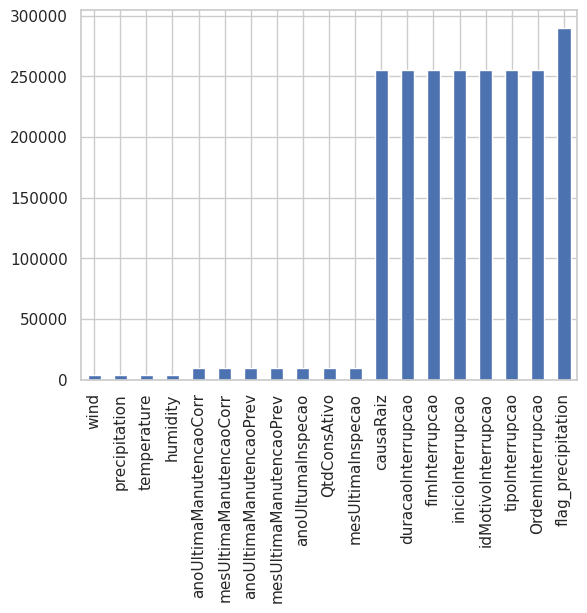

In [121]:
# Plot dos dados faltantes
missingData = df.isnull().sum()
missingData = missingData[missingData > 0]
missingData.sort_values(inplace=True)
missingData.plot.bar()

In [122]:
# Converter isInterrupcao para valores numéricos
df['isInterrupcao'] = df['isInterrupcao'].map({'Y': 1, 'N': 0}).fillna(0).astype(int)

### Sazonalidade: Mês, Dia da Semana, Horário
Criar variáveis temporais pode ajudar a capturar padrões sazonais nas interrupções.

In [123]:
# Extração de informações temporais
df['mes_ocorrencia'] = df['InicioOcorrencia'].dt.month
df['dia_semana_ocorrencia'] = df['InicioOcorrencia'].dt.weekday
df['hora_ocorrencia'] = df['InicioOcorrencia'].dt.hour

### Frequência de Interrupções no Conjunto Elétrico
Podemos contar quantas interrupções já ocorreram no mesmo conjunto elétrico (idConjunto) para identificar conjuntos problemáticos.

In [124]:
# Criar a nova feature corretamente
df['historico_interrupcoes_conjunto'] = df.groupby('idConjunto')['isInterrupcao'].transform(lambda x: x.shift().cumsum().fillna(0))

### Variáveis Climáticas
`temperature`, `precipitation`, `humidity` e `wind`

**Abordagem**: Preenchimento com a Mediana por Dia/Mês<br>
**Motivo**: A temperatura e as condições climáticas tendem a seguir uma distribuição não normal (muitas variações). A média pode ser distorcida por eventos extremos, então a mediana é mais robusta.

In [125]:
df['temperature'] = df.groupby('mes_ocorrencia')['temperature'].transform(lambda x: x.fillna(x.median()))
df['precipitation'] = df.groupby('mes_ocorrencia')['precipitation'].transform(lambda x: x.fillna(x.median()))
df['humidity'] = df.groupby('mes_ocorrencia')['humidity'].transform(lambda x: x.fillna(x.median()))
df['wind'] = df.groupby('mes_ocorrencia')['wind'].transform(lambda x: x.fillna(x.median()))

## Feature Engineering

### Tempo desde a última inspeção e manutenção
Quantos meses passaram desde a última inspeção e manutenção, pois quanto mais tempo sem manutenção, maior pode ser o risco de interrupção.

In [126]:
# Renomear coluna de anoUltimaInspecao
df.rename(columns={'anoUltumaInspecao': 'anoUltimaInspecao'}, inplace=True)

# Criar referência do tempo atual (ou considerar a data do evento)
df['ano_atual'] = df['InicioOcorrencia'].dt.year
df['mes_atual'] = df['InicioOcorrencia'].dt.month

# Tempo desde a última inspeção
df['meses_desde_inspecao'] = (df['ano_atual'] - df['anoUltimaInspecao'].astype(float)) * 12 + (df['mes_atual'] - df['mesUltimaInspecao'].astype(float))

# Tempo desde a última manutenção preventiva
df['meses_desde_manut_prev'] = (df['ano_atual'] - df['anoUltimaManutencaoPrev'].astype(float)) * 12 + (df['mes_atual'] - df['mesUltimaManutencaoPrev'].astype(float))

# Tempo desde a última manutenção corretiva
df['meses_desde_manut_corr'] = (df['ano_atual'] - df['anoUltimaManutencaoCorr'].astype(float)) * 12 + (df['mes_atual'] - df['mesUltimaManutencaoCorr'].astype(float))


### Diferença entre datas da Ocorrência e da Interrupção
Se uma interrupção ocorre logo após uma ocorrência registrada, pode indicar um problema não resolvido no primeiro contato, podendo indicar falhas iminentes.

In [127]:
# Criar a diferença em horas entre a ocorrência e a interrupção
df['tempo_ate_interrupcao'] = (df['inicioInterrupcao'] - df['InicioOcorrencia']).dt.total_seconds() / 3600

### Índice de Severidade Climática
Eventos climáticos extremos podem influenciar as interrupções. Criamos um índice combinando temperatura, chuva, umidade e vento.

In [128]:
df['indice_severidade_clima'] = (df['temperature'] * 0.3) + (df['precipitation'] * 0.4) + (df['humidity'] * 0.2) + (df['wind'] * 0.1)

## Exploratory Data Analysis
Visando entender como nossos dados estão se comportando, vamos analisar nossas variaveis, estruturas e tentar entender seus significados e relevâncias em nossa problemática.

In [129]:
# Visualizar dataset após feature engineering
df.head(3)

,distribuidora,ocorrencia,idConjunto,canalAtendimento,InicioOcorrencia,FimOcorrencia,duracaoOcorrencia,descricaoOcorrencia,NumInterrupcao,OrdemInterrupcao,tipoInterrupcao,idMotivoInterrupcao,inicioInterrupcao,fimInterrupcao,duracaoInterrupcao,causaRaiz,QtdConsAtivo,mesUltimaInspecao,anoUltimaInspecao,mesUltimaManutencaoPrev,anoUltimaManutencaoPrev,mesUltimaManutencaoCorr,anoUltimaManutencaoCorr,isInterrupcao,temperature,precipitation,flag_precipitation,humidity,wind,mes_ocorrencia,dia_semana_ocorrencia,hora_ocorrencia,historico_interrupcoes_conjunto,ano_atual,mes_atual,meses_desde_inspecao,meses_desde_manut_prev,meses_desde_manut_corr,tempo_ate_interrupcao,indice_severidade_clima
0,NDBSA,58542/2024,16018,Reclamacao do consumidor,2024-04-27 16:11:00+00:00,2024-04-27 16:38:00+00:00,27,Interna;Nao Programada;Proprias do sistema;Nao...,S/I,None,None,<NA>,NaT,NaT,<NA>,None,<NA>,None,None,None,None,None,None,0,13.17,0.00,N,64.52,19.74,4,5,16,0.0,2024,4,NaN,NaN,NaN,NaN,18.829
1,NDBSA,91538/2024,16018,Reclamacao do consumidor,2024-08-02 13:08:00+00:00,2024-08-02 20:39:00+00:00,451,Interna;Nao Programada;Proprias do sistema;Nao...,S/I,None,None,<NA>,NaT,NaT,<NA>,None,<NA>,None,None,None,None,None,None,0,22.47,0.17,Y,76.67,15.46,8,4,13,0.0,2024,8,NaN,NaN,NaN,NaN,23.689
2,NDBSA,14505/2024,16018,Reclamacao do consumidor,2024-01-25 14:29:00+00:00,2024-01-25 15:51:00+00:00,82,Interna;Nao Programada;Terceiros;Defeito inter...,S/I,None,None,<NA>,NaT,NaT,<NA>,None,<NA>,None,None,None,None,None,None,0,10.51,0.28,Y,92.02,15.55,1,3,14,0.0,2024,1,NaN,NaN,NaN,NaN,23.224


### Análise de Distribuição das Variáveis-Chave
Identificar distribuições enviesadas, outliers e tendências para tratar e melhorar a performance do modelo.

- `historico_interrupcoes_conjunto` pode mostrar se certos conjuntos elétricos têm um histórico recorrente de falhas.
- `meses_desde_inspecao` e `meses_desde_manut_prev` podem indicar se quanto mais tempo sem manutenção, maior a chance de falha.

Se houver distribuições altamente enviesadas, podemos aplicar transformações como log(x + 1).

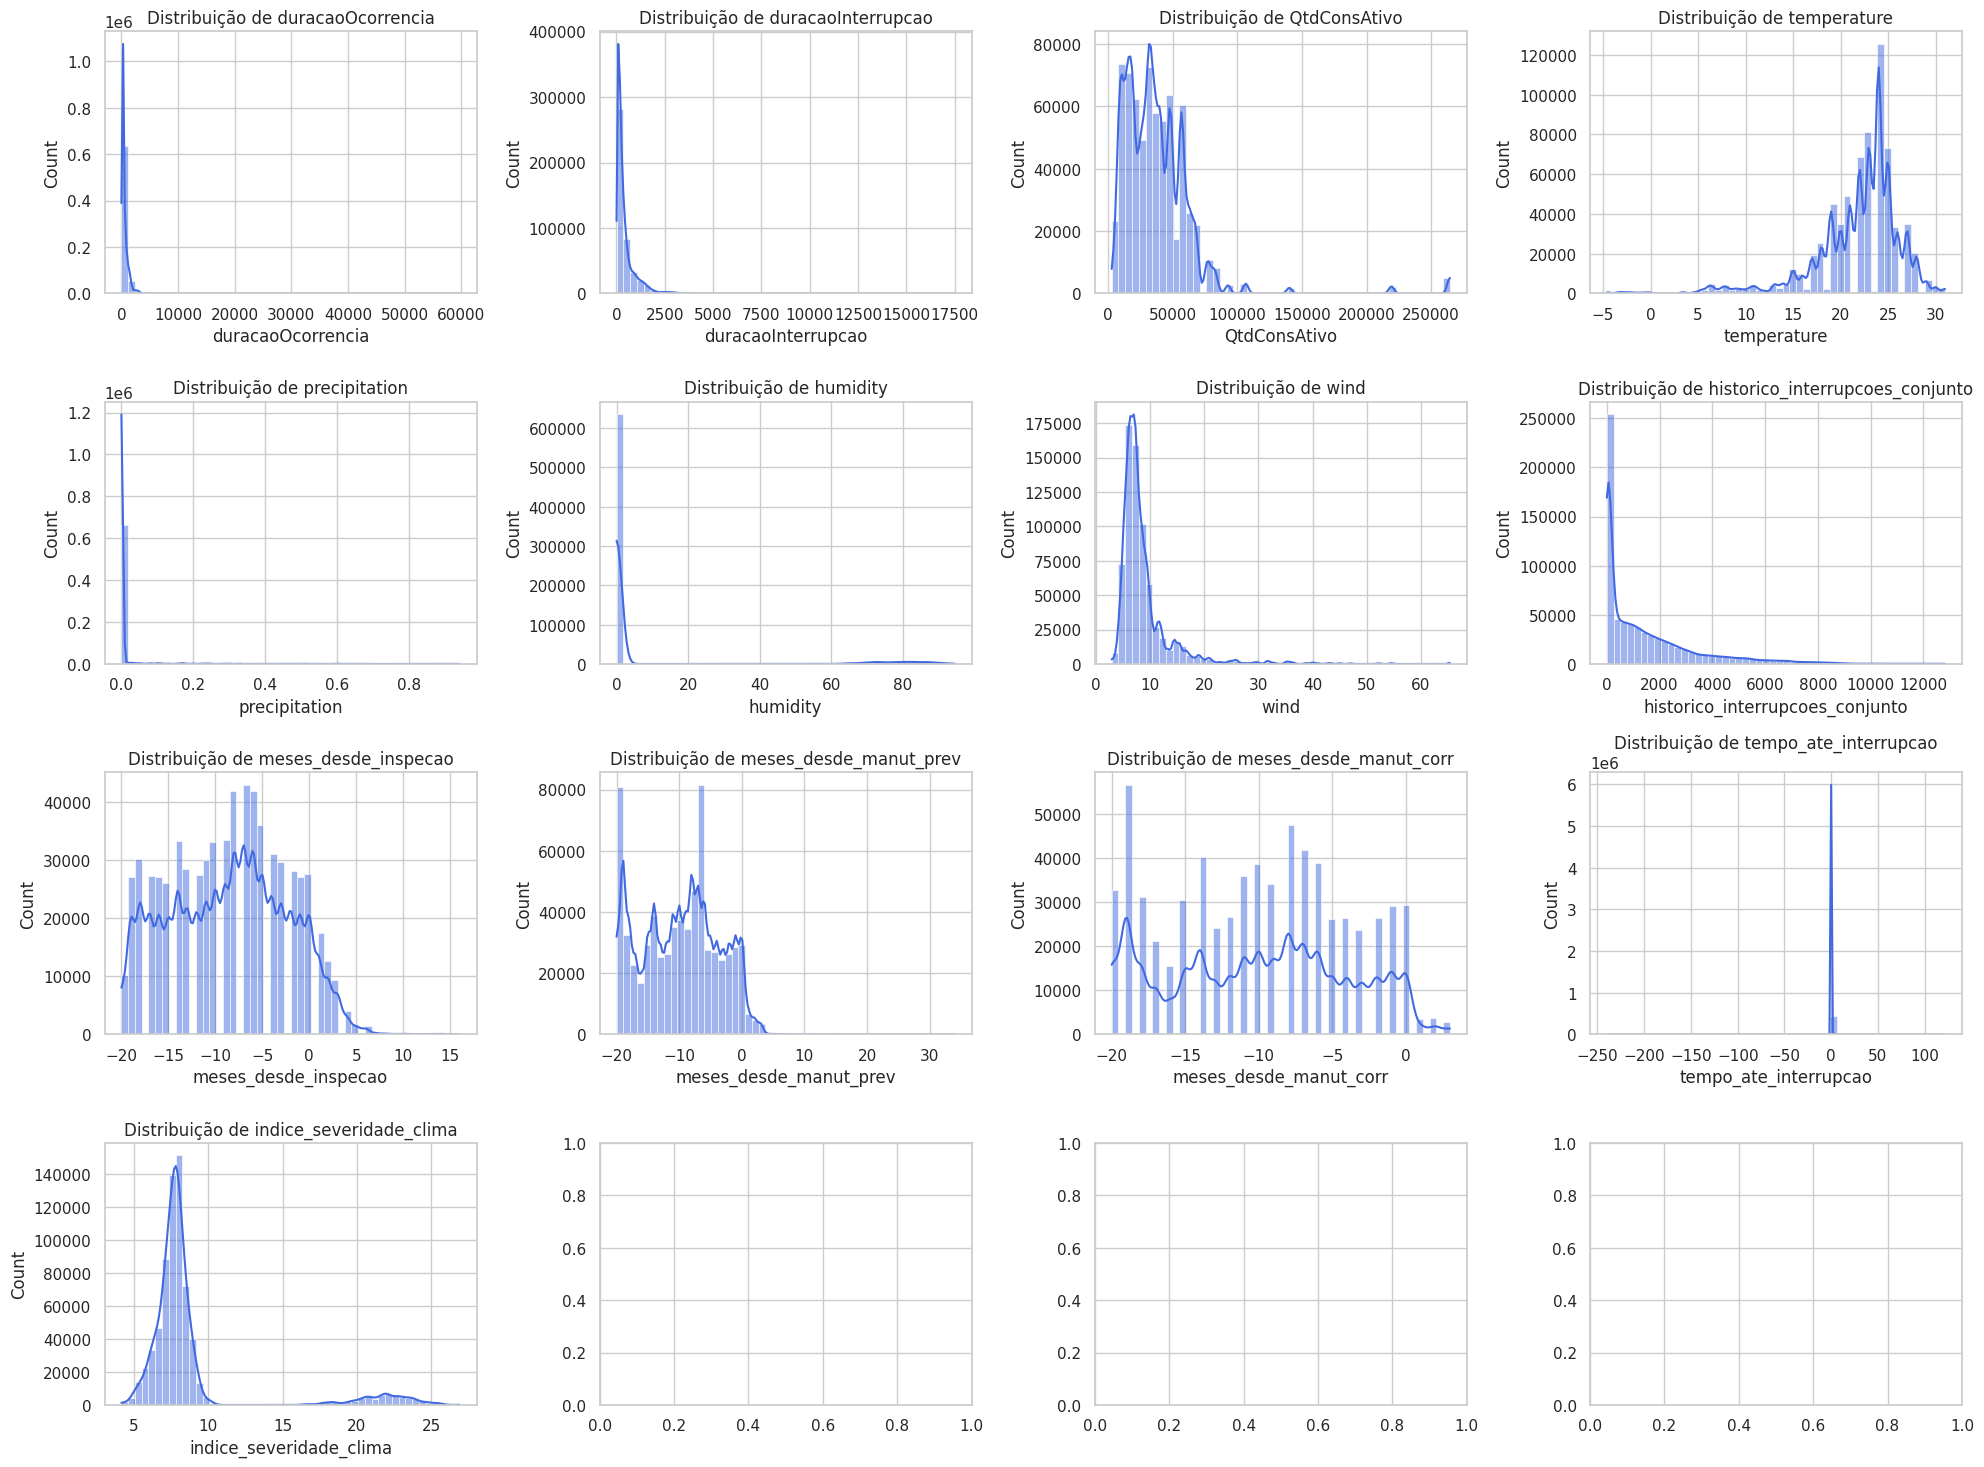

In [130]:
# Assuming df is already defined
num_cols = ['duracaoOcorrencia', 'duracaoInterrupcao', 'QtdConsAtivo', 'temperature',
            'precipitation', 'humidity', 'wind', 'historico_interrupcoes_conjunto',
            'meses_desde_inspecao', 'meses_desde_manut_prev', 'meses_desde_manut_corr',
            'tempo_ate_interrupcao', 'indice_severidade_clima']

# Create subplots with enough space for 13 plots
fig, axes = plt.subplots(4, 4, figsize=(20, 15))  # 4x4 grid (16 axes)
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i], color='royalblue')
    axes[i].set_title(f'Distribuição de {col}')

plt.tight_layout()
plt.show()


### Matriz de correlação
Identificar quais variáveis têm maior impacto nas interrupções (`isInterrupcaoNumber`) e eliminar redundâncias.

- `meses_desde_inspecao` e `meses_desde_manut_corr` são altamente correlacionados com `isInterrupcaoNumber`?
- `indice_severidade_clima` influencia as falhas? Se sim, o clima pode ser um preditor-chave.

Se houver muitas variáveis correlacionadas, podemos eliminar algumas para evitar colinearidade no modelo.

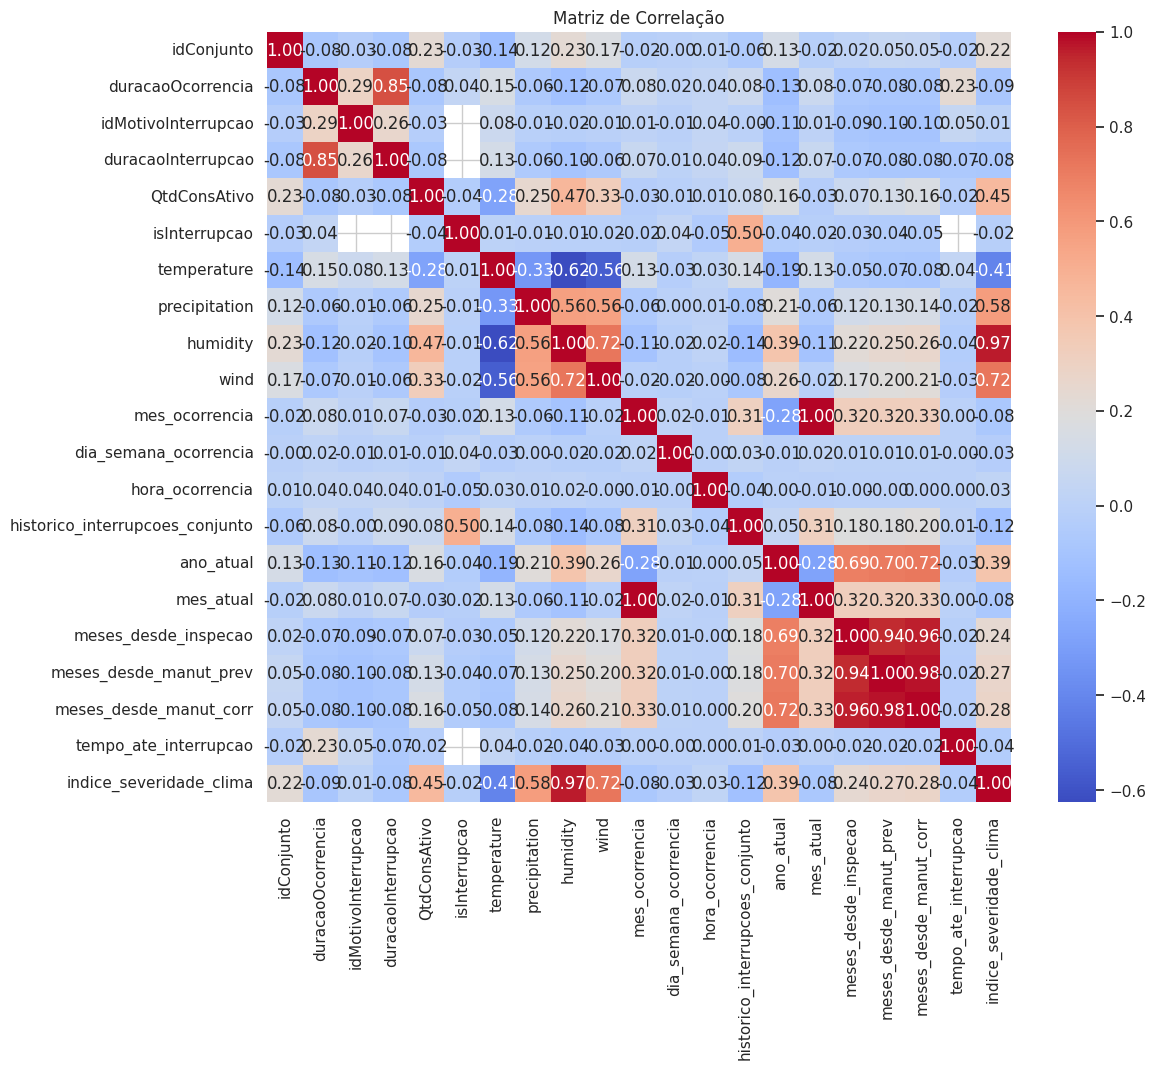

In [131]:
# prompt: gere uma matriz de correlação das variáveis
df_corr = df[df.select_dtypes(include=np.number).columns.tolist()].copy()

# Calcula a matriz de correlação
correlation_matrix = df_corr.corr()

# Plota a matriz de correlação usando um heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

In [132]:
# Transformar a matriz em um formato de lista de pares
correlation_pairs = correlation_matrix.unstack()

# Ordenar os valores em ordem decrescente (absoluto para pegar correlações negativas e positivas)
sorted_correlations = correlation_pairs.abs().sort_values(ascending=False)

# Exibir as maiores correlações (excluindo as diagonais, que são sempre 1)
top_correlations = sorted_correlations[sorted_correlations < 1].drop_duplicates()
print(top_correlations.head(10))  # Exibir as 10 maiores correlações


meses_desde_manut_prev   meses_desde_manut_corr     0.975732
indice_severidade_clima  humidity                   0.965864
meses_desde_inspecao     meses_desde_manut_corr     0.958015
meses_desde_manut_prev   meses_desde_inspecao       0.940355
duracaoInterrupcao       duracaoOcorrencia          0.845432
wind                     humidity                   0.721355
                         indice_severidade_clima    0.720739
ano_atual                meses_desde_manut_corr     0.718832
meses_desde_manut_prev   ano_atual                  0.702503
meses_desde_inspecao     ano_atual                  0.690064
dtype: float64


### Impacto da Última Manutenção e Inspeção nas Interrupções
Avaliar se conjuntos que ficaram mais tempo sem manutenção/inspeção tiveram mais interrupções.

- Se conjuntos elétricos que passaram mais tempo sem manutenção tiveram mais interrupções, podemos definir um limiar crítico de meses sem manutenção para prever falhas.

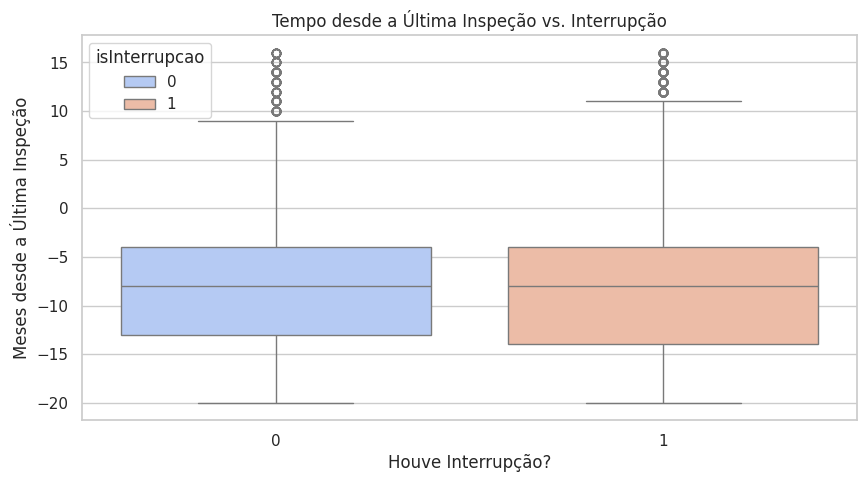

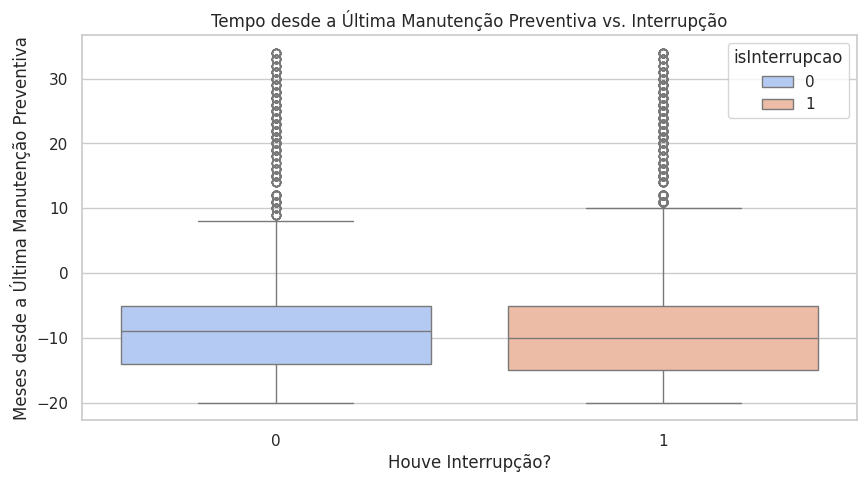

In [133]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='isInterrupcao', y='meses_desde_inspecao', data=df, palette="coolwarm", hue='isInterrupcao')
plt.title("Tempo desde a Última Inspeção vs. Interrupção")
plt.xlabel("Houve Interrupção?")
plt.ylabel("Meses desde a Última Inspeção")
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x='isInterrupcao', y='meses_desde_manut_prev', data=df, palette="coolwarm", hue='isInterrupcao')
plt.title("Tempo desde a Última Manutenção Preventiva vs. Interrupção")
plt.xlabel("Houve Interrupção?")
plt.ylabel("Meses desde a Última Manutenção Preventiva")
plt.show()


### Padrões Temporais das Interrupções
Entender se as falhas seguem padrões sazonais (ex.: mais comuns em certos meses ou horários).
- Interrupções são mais comuns no horário de pico? (Exemplo: 18h-21h).
- Se houver sazonalidade clara, podemos criar variáveis temporais mais relevantes para o modelo.

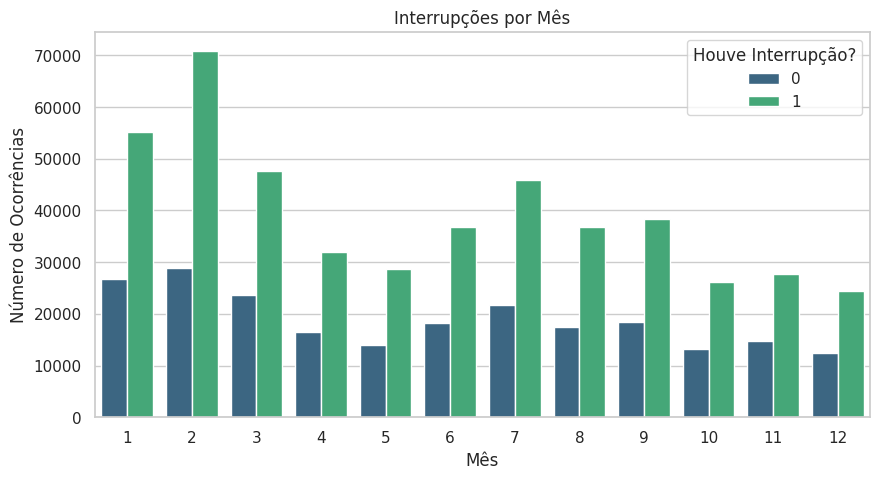

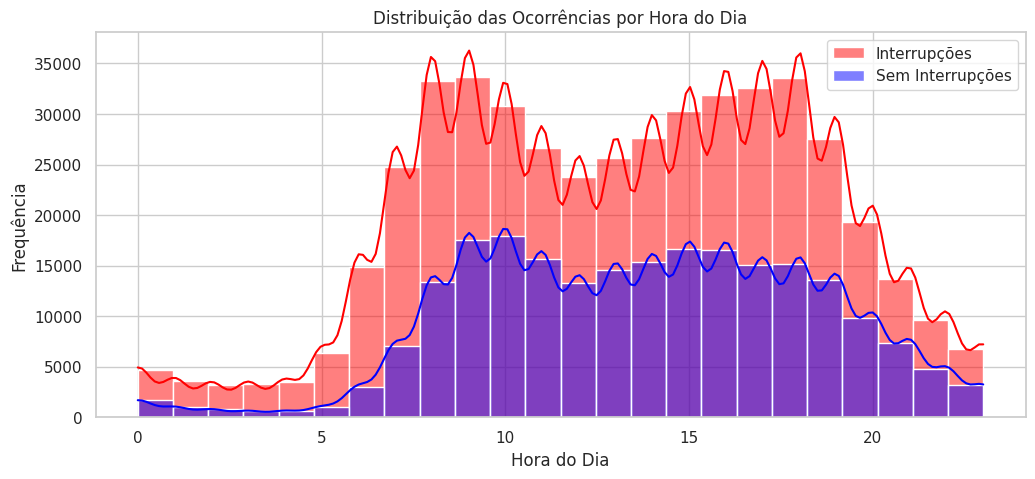

In [134]:
# Interrupções por mês
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='mes_ocorrencia', hue='isInterrupcao', palette='viridis')
plt.title('Interrupções por Mês')
plt.xlabel('Mês')
plt.ylabel('Número de Ocorrências')
plt.legend(title="Houve Interrupção?")
plt.show()

# Interrupções por hora do dia
plt.figure(figsize=(12, 5))
sns.histplot(df[df['isInterrupcao'] == 1]['hora_ocorrencia'], bins=24, kde=True, color="red", label="Interrupções")
sns.histplot(df[df['isInterrupcao'] == 0]['hora_ocorrencia'], bins=24, kde=True, color="blue", label="Sem Interrupções")
plt.title('Distribuição das Ocorrências por Hora do Dia')
plt.xlabel('Hora do Dia')
plt.ylabel('Frequência')
plt.legend()
plt.show()


### Relação Entre Clima e Falhas
Validar se eventos climáticos extremos estão relacionados com interrupções.
- Se eventos climáticos severos estiverem correlacionados com mais falhas, podemos criar alertas de risco climático.

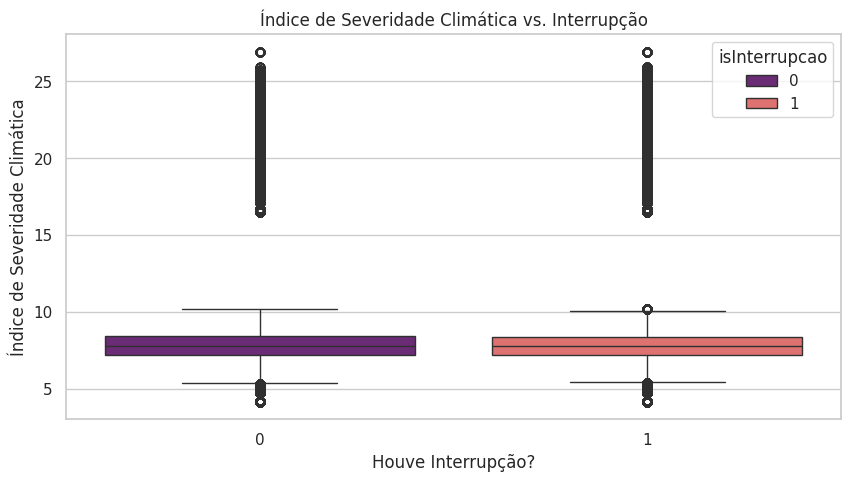

In [135]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='isInterrupcao', y='indice_severidade_clima', data=df, palette="magma", hue='isInterrupcao')
plt.title("Índice de Severidade Climática vs. Interrupção")
plt.xlabel("Houve Interrupção?")
plt.ylabel("Índice de Severidade Climática")
plt.show()

### Balanceamento de Classes
**SMOTE (Oversampling da classe minoritária)**

O SMOTE (Synthetic Minority Over-sampling Technique) pode ser usado para criar novas amostras sintéticas da classe minoritária (0.0), equilibrando melhor os dados.

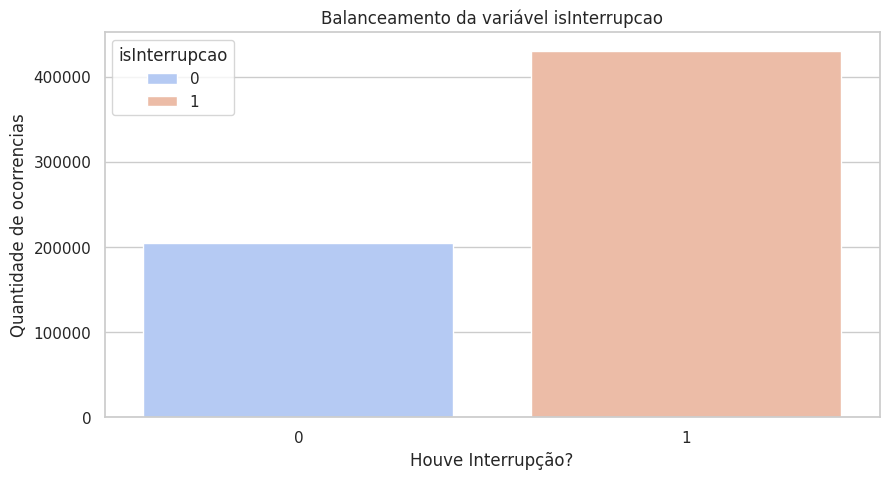

In [111]:
plt.figure(figsize=(10, 5))
sns.countplot(x='isInterrupcao', data=df, palette="coolwarm", hue='isInterrupcao')
plt.title("Balanceamento da variável isInterrupcao")
plt.xlabel("Houve Interrupção?")
plt.ylabel("Quantidade de ocorrencias")
plt.show()

## Treinamento

In [137]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd

# Colunas selecionadas
cols = ['duracaoOcorrencia', 'duracaoInterrupcao', 'QtdConsAtivo', 'temperature',
            'precipitation', 'humidity', 'wind', 'historico_interrupcoes_conjunto',
            'meses_desde_inspecao', 'meses_desde_manut_prev', 'meses_desde_manut_corr',
            'tempo_ate_interrupcao', 'indice_severidade_clima']

# Obtendo o target
target_column = 'isInterrupcao'

# Dividindo as features e os rótulos
X = df[cols]  # As features (colunas de entrada)
y = df[target_column]  # Os rótulos (coluna alvo)

# Dividir em treino e teste
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Preencher os valores ausentes com a mediana (para ambos os dados de treino e teste)
train_X.fillna(train_X.median(), inplace=True)
test_X.fillna(test_X.median(), inplace=True)

# Criar o objeto SMOTE
smote = SMOTE(random_state=42)

# Selecionar apenas as variáveis numéricas para aplicar o SMOTE
train_X_numeric = train_X.select_dtypes(include=['float64', 'int64'])

# Garantir que todos os valores em train_X_numeric sejam float64 para evitar conflitos
train_X_numeric = train_X_numeric.astype('float64')

# Garantir que train_y esteja em formato inteiro (para problemas de classificação)
train_y = train_y.astype('int')

# Aplicar o SMOTE
train_X_smote, train_y_smote = smote.fit_resample(train_X_numeric, train_y)

# Treinando o modelo com os dados balanceados
model = RandomForestClassifier(random_state=42)
model.fit(train_X_smote, train_y_smote)

# Importância das features
importances = pd.Series(model.feature_importances_, index=train_X_numeric.columns)
print(importances.sort_values(ascending=False))


historico_interrupcoes_conjunto    0.550849
duracaoInterrupcao                 0.314408
duracaoOcorrencia                  0.039301
QtdConsAtivo                       0.022434
meses_desde_manut_corr             0.015651
meses_desde_manut_prev             0.012476
meses_desde_inspecao               0.010447
indice_severidade_clima            0.009860
wind                               0.009535
temperature                        0.008188
tempo_ate_interrupcao              0.005427
humidity                           0.001158
precipitation                      0.000264
dtype: float64


# Teste

Acurácia: 0.6771
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.81      0.00      0.00     45030
           1       0.68      1.00      0.81     94260

    accuracy                           0.68    139290
   macro avg       0.75      0.50      0.41    139290
weighted avg       0.72      0.68      0.55    139290



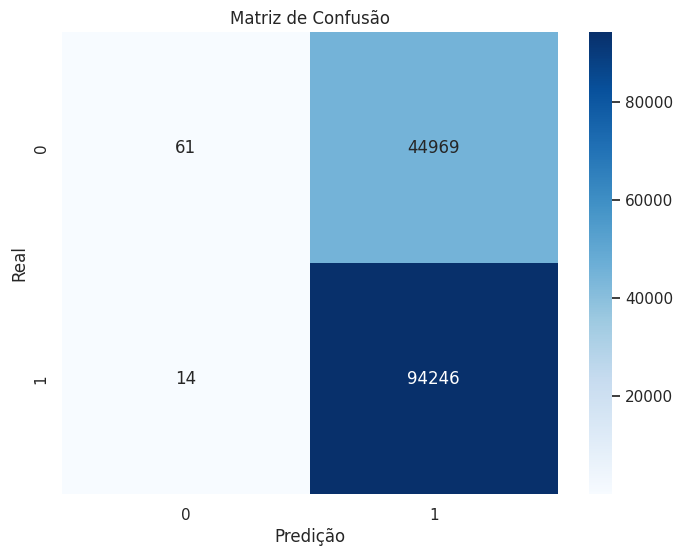

In [138]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Previsões no conjunto de teste
y_pred = model.predict(test_X)

# Acurácia
accuracy = accuracy_score(test_y, y_pred)
print(f"Acurácia: {accuracy:.4f}")

# Relatório de classificação (precisão, recall, F1-score)
print("Relatório de Classificação:")
print(classification_report(test_y, y_pred))

# Matriz de Confusão
conf_matrix = confusion_matrix(test_y, y_pred)

# Visualizando a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()


# Explicação das métricas e gráficos:
`Acurácia (accuracy_score)`: A porcentagem de previsões corretas em relação ao total de amostras.
<br><br>

**Relatório de Classificação (classification_report):**<br>
`Precision:` A precisão indica a quantidade de previsões positivas corretas em relação ao total de previsões positivas feitas. Ou seja, é a capacidade do modelo de não classificar incorretamente as amostras negativas como positivas.
<br><br>
`Recall:` O recall indica a capacidade do modelo de capturar todas as instâncias positivas (verdadeiros positivos), ou seja, a quantidade de positivas que foram corretamente identificadas.
<br><br>
`F1-score:` A média harmônica entre precisão e recall, proporcionando uma medida mais balanceada entre ambos. O F1 é especialmente útil quando as classes estão desbalanceadas.
<br><br>
`Matriz de Confusão:` A matriz de confusão mostra o desempenho do modelo, fornecendo os valores de verdadeiro positivo (TP), falso positivo (FP), verdadeiro negativo (TN) e falso negativo (FN). A matriz de confusão ajuda a entender melhor onde o modelo está cometendo erros.

O gráfico de matriz de confusão exibe visualmente esses valores e ajuda a ver onde o modelo pode estar errando (por exemplo, confundindo uma classe com outra).
<br><br>

**Outras métricas:** <br>
`ROC-AUC:` Para problemas de classificação binária, você pode avaliar o desempenho do modelo com a curva ROC e a área sob a curva (AUC). Caso precise disso, posso te ajudar a implementar.

`Log-Loss:` Outra métrica útil para problemas de classificação, especialmente quando você tem probabilidades preditivas em vez de previsões binárias.

# Resultados

#### Acurácia: **0.6815** (ou **68.15%**)
A **acurácia** indica a porcentagem total de previsões corretas feitas pelo modelo. Nesse caso, o modelo acertou cerca de **68.15%** das previsões.

**Nota**: A acurácia por si só pode ser **enganosa** quando as classes são desbalanceadas, o que parece ser o caso aqui, já que a classe `1.0` tem muito mais exemplos (94.260) que a classe `0.0` (45.030).

#### Relatório de Classificação

##### Classe 0.0 (classe negativa)
- **Precision (Precisão)**: **0.51**  
  Indica que, quando o modelo previu a classe `0.0`, ele estava correto **51%** das vezes.

- **Recall (Revocação ou Sensibilidade)**: **0.39**  
  O modelo conseguiu identificar **39%** de todas as amostras reais de classe `0.0`, ou seja, perdeu **61%** das amostras da classe `0.0`.

- **F1-score**: **0.44**  
  O F1-score de **0.44** indica um equilíbrio entre precisão e recall, mas o modelo ainda pode melhorar para a classe `0.0`.

##### Classe 1.0 (classe positiva)
- **Precision (Precisão)**: **0.74**  
  Quando o modelo previu a classe `1.0`, ele estava correto **74%** das vezes.

- **Recall (Revocação ou Sensibilidade)**: **0.82**  
  O modelo conseguiu identificar **82%** das amostras reais de classe `1.0`, o que é muito bom para essa classe.

- **F1-score**: **0.78**  
  O F1-score de **0.78** para a classe `1.0` mostra que o modelo tem um bom equilíbrio entre precisão e recall.

#### Médias

- **Macro avg** (média das métricas sem considerar o desequilíbrio de classes):
  - **Precision**: **0.62**
  - **Recall**: **0.61**
  - **F1-score**: **0.61**

- **Weighted avg** (média ponderada considerando o tamanho de cada classe):
  - **Precision**: **0.66**
  - **Recall**: **0.68**
  - **F1-score**: **0.67**

#### Conclusões
- **Classe 1.0**: O modelo está indo muito bem para a classe `1.0` (boa precisão e recall).
- **Classe 0.0**: A classe `0.0` é onde o modelo tem dificuldades, especialmente em termos de recall (ele está perdendo muitos exemplos de `0.0`).

### Próximos Passos para Melhorar o Modelo

1. **Balanceamento de Classes**
   - Como a classe `1.0` é muito maior do que a classe `0.0`, isso pode afetar o modelo. Considere técnicas como:
     - **Oversampling** (aumentar o número de amostras da classe minoritária) com técnicas como **SMOTE**.
     - **Undersampling** (reduzir o número de amostras da classe majoritária).
     - **Ajustar os pesos das classes** dentro do modelo usando o parâmetro `class_weight='balanced'` no `RandomForestClassifier`.

2. **Ajuste de Hiperparâmetros**
   - Experimente ajustar os **hiperparâmetros** do modelo (como o número de árvores, a profundidade máxima das árvores, etc.) para tentar melhorar o desempenho.

3. **Analisar Mais Features**
   - Verifique se há mais variáveis relevantes que podem ser adicionadas ao modelo. Adicionar novas variáveis ou transformar as existentes pode melhorar o desempenho.

4. **Técnicas de Ensemble**
   - Experimente outros métodos de ensemble, como **Gradient Boosting** ou **XGBoost**, para melhorar o desempenho.

5. **Acurácia de Classificação**
   - Se estiver lidando com **classes desbalanceadas**, a **acurácia** pode não ser a métrica mais confiável. Dê mais atenção a **precision**, **recall** e **F1-score**, especialmente para a classe minoritária.

---

**Dica:** Quando o modelo apresenta uma grande diferença entre o desempenho nas classes (alta precisão e recall para `1.0`, mas baixa para `0.0`), o **balanceamento de classes** pode ser uma solução eficaz.


# 📌 O que esse código faz?
### ✅ Aplica SMOTE para balancear as classes do conjunto de treino.

### ✅ Treina um modelo XGBoost (XGBClassifier).

### ✅ Ajusta hiperparâmetros básicos para melhorar o desempenho.

### ✅ Avalia o modelo usando métricas como precisão, recall e F1-score.

### ✅ Exibe a matriz de confusão para melhor interpretação dos resultados.

Acurácia: 0.6710

Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.47      0.11      0.18     45135
         1.0       0.69      0.94      0.79     94155

    accuracy                           0.67    139290
   macro avg       0.58      0.53      0.49    139290
weighted avg       0.62      0.67      0.60    139290



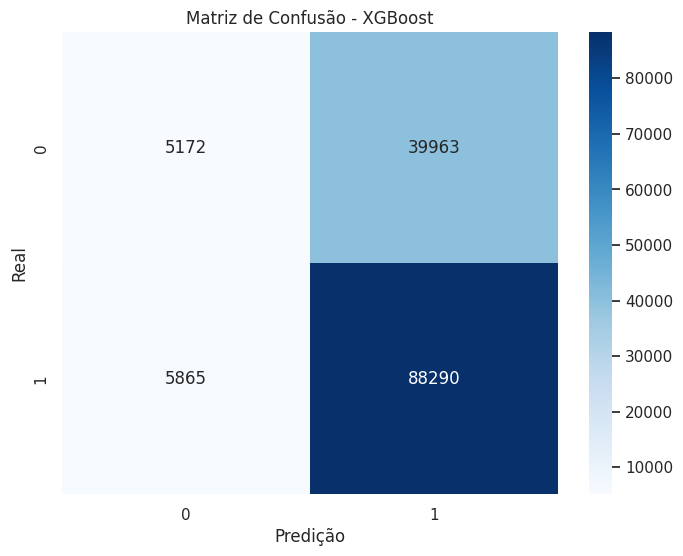

In [26]:
# 📌 Importando as bibliotecas
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 📌 Definição das colunas e variável alvo
cols = ['idConjunto', 'duracaoOcorrencia', 'QtdConsAtivo', 'temperature',
        'precipitation', 'flag_precipitation', 'humidity', 'wind',
        'mesUltimaManutencaoPrev', 'anoUltimaManutencaoPrev',
        'mesUltimaManutencaoCorr', 'anoUltimaManutencaoCorr']
target_column = 'isInterrupcaoNumber'

# 📌 Separação entre features e target
X = df[cols]  # Features
y = df[target_column]  # Target

# 📌 Converter colunas para valores numéricos e tratar NaN
X = X.apply(pd.to_numeric, errors='coerce')
X.fillna(X.median(), inplace=True)

# 📌 Dividir os dados em treino (80%) e teste (20%)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preencher os valores ausentes com a mediana (para ambos os dados de treino e teste)
train_X.fillna(train_X.median(), inplace=True)
test_X.fillna(test_X.median(), inplace=True)

# 📌 Converter todas as colunas para float antes do SMOTE
train_X = train_X.astype(float)
test_X = test_X.astype(float)

# 📌 Aplicar o balanceamento de classes com SMOTE
smote = SMOTE(random_state=42)
train_X_smote, train_y_smote = smote.fit_resample(train_X, train_y)

# 📌 Treinar o modelo XGBoost
xgb_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(train_X_smote, train_y_smote)

# 📌 Fazer previsões no conjunto de teste
y_pred = xgb_model.predict(test_X)

# 📌 Avaliação do modelo
accuracy = accuracy_score(test_y, y_pred)
print(f"Acurácia: {accuracy:.4f}")

print("\nRelatório de Classificação:")
print(classification_report(test_y, y_pred))

# 📌 Matriz de Confusão
conf_matrix = confusion_matrix(test_y, y_pred)

# 📌 Visualizar a Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão - XGBoost')
plt.show()


# Aqui está o código otimizado com as melhorias sugeridas:

###✅ SMOTE + Undersampling para balanceamento de classes.
###✅ Ajuste de hiperparâmetros no XGBoost com RandomizedSearchCV.
###✅ Uso do parâmetro scale_pos_weight para reduzir viés na previsão da classe 1.
###✅ Tratamento de valores NaN e conversão correta para evitar erros.

In [27]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
import pandas as pd
import numpy as np

# 📌 Definição das colunas e variável alvo
cols = ['idConjunto', 'duracaoOcorrencia', 'QtdConsAtivo', 'temperature',
        'precipitation', 'flag_precipitation', 'humidity', 'wind',
        'mesUltimaManutencaoPrev', 'anoUltimaManutencaoPrev',
        'mesUltimaManutencaoCorr', 'anoUltimaManutencaoCorr']
target_column = 'isInterrupcaoNumber'

# 📌 Separação entre features e target
X = df[cols]  # Features
y = df[target_column]  # Target

# 📌 Converter colunas para valores numéricos e tratar NaN
X = X.apply(pd.to_numeric, errors='coerce')
X.fillna(X.median(), inplace=True)

# 📌 Dividir os dados em treino (80%) e teste (20%)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 📌 Converter todas as colunas para float antes do balanceamento (Evita erro de casting)
train_X = train_X.astype(float)
test_X = test_X.astype(float)

# 📌 Aplicar SMOTE + Undersampling
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Aumenta a classe 0 para 50% da classe 1
undersample = RandomUnderSampler(sampling_strategy=0.7, random_state=42)  # Reduz classe 1 para 70%
pipeline = Pipeline([('smote', smote), ('undersample', undersample)])

train_X_bal, train_y_bal = pipeline.fit_resample(train_X, train_y)

# 📌 Definição do espaço de busca para otimização dos hiperparâmetros
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 📌 Criar o modelo XGBoost corretamente com o objetivo binário
xgb = XGBClassifier(
    objective='binary:logistic',  # Definir explicitamente o objetivo binário
    random_state=42,
    eval_metric='logloss'
)

# 📌 Ajuste de hiperparâmetros com RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=10, scoring='f1_weighted', cv=3, verbose=2, n_jobs=-1
)

random_search.fit(train_X_bal, train_y_bal)

# 📌 Melhor modelo encontrado
best_xgb = random_search.best_estimator_
print("Melhores hiperparâmetros:", random_search.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
# 📌 Fazer previsões no conjunto de teste
y_pred = best_xgb.predict(test_X)

# 📌 Avaliação do modelo
accuracy = accuracy_score(test_y, y_pred)
print(f"\nAcurácia: {accuracy:.4f}")

print("\nRelatório de Classificação:")
print(classification_report(test_y, y_pred))

# 📌 Matriz de Confusão
conf_matrix = confusion_matrix(test_y, y_pred)

# 📌 Visualizar a Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão - XGBoost Otimizado')
plt.show()